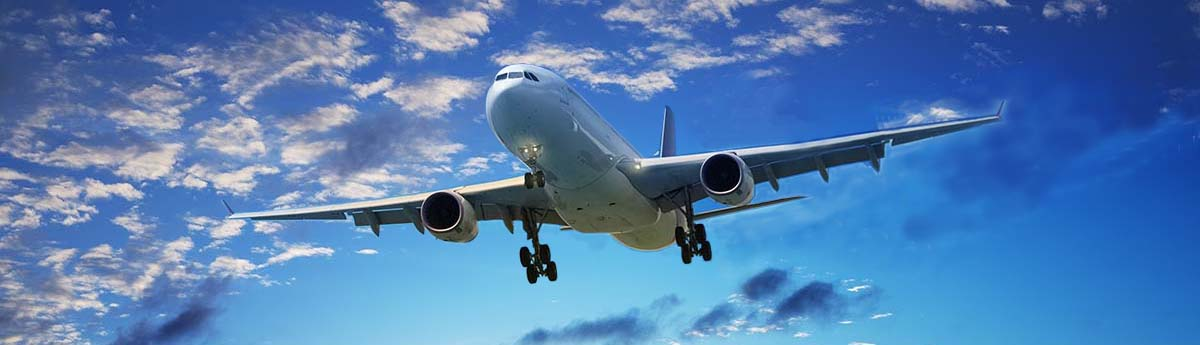

# <center> Предсказание удовлетворенности полетом

Мы будем работать c [данными](https://lms.skillfactory.ru/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block@AirPass.zip), которые содержат результаты опроса клиентов авиакомпании по поводу их удовлетворённости полётом.

Нашей задачей будет предсказать удовлетворённость пассажиров.

Подгрузим инструментарий.

In [1]:
# Для работы с данными
import pandas as pd
import numpy as np
# Для построения моеделй
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn import metrics
# Для графики и отображения
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-v0_8')
# Подавление предупреждений
import warnings
warnings.filterwarnings('ignore')

## Загрузка и обработка данных

Загрузим данные.

In [2]:
# airpass data frame
apdf = pd.read_csv('data/AirPass.zip')
apdf.drop(apdf.columns[0], axis=1, inplace=True)
apdf.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied



|feature|description|feature|description|
|-|-|-|-|
|`Gender`|пол пассажира (женский, мужской)|`Seat comfort`|уровень удовлетворённости комфортом сидений|
|`Customer Type`|тип клиента (постоянный/непостоянный клиент)|`Inflight entertainment`|уровень удовлетворённости развлечениями на борту|
|`Age`|возраст клиента|`On-board service`|уровень удовлетворённости сервисом на борту|
|`Type of Travel`|цель перелета (личная/деловая поездка)|`Leg room service`|уровень удовлетворённости местом для ног|
|`Class`|туристический класс пассажира (Business, Eco, Eco Plus)|`Baggage handling`|уровень удовлетворённости обработкой багажа|
|`Flight distance`|расстояние полета|`Check-in service`|уровень удовлетворённости услугами регистрации|
|`Inflight wifi service`|уровень удовлетворённости Wi-Fi (0 — не применимо, 1–5)|`Inflight service`|уровень удовлетворённости обслуживанием во время полёта|
|`Departure/Arrival time convenient`|уровень удовлетворённости временем отправления и прибытия|`Cleanliness`|уровень удовлетворённости чистотой|
|`Ease of Online booking`|уровень удовлетворённости онлайн-бронированием|`Departure Delay in Minutes`|задержка при отправлении (в минутах)|
|`Gate location`|уровень удовлетворённости расположением выхода на посадку|`Arrival Delay in Minutes`|задержка при прибытии (в минутах)|
|`Food and drink`|уровень удовлетворённости едой и напитками|`Satisfaction`|удовлетворённость авиакомпанией — целевая переменная (satisfaction/neutral/dissatisfaction)|
|`Online boarding`|уровень удовлетворённости онлайн-регистрацией|-|-|

Взглянем на число пропущенных значений в данных по признакам.

In [3]:
apdf.isna().sum()

id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction                           0
dtype: int64

Имеются пропуски только в признаке, характеризующем задержки при прибытии.

Заполним эти пропуски медианными значениями.

In [4]:
apdf['Arrival Delay in Minutes'] = apdf[
    'Arrival Delay in Minutes'
].fillna(apdf['Arrival Delay in Minutes'].median())

Проведём небольшой разведывательный анализ. Посмотрим, в каких категориях пассажиров превалировали удовлетворённые полетом клиенты.

1. Сравним удовлетворённость полётом мужчин и женщин.

In [5]:
grpd1 = apdf.groupby('Gender')['satisfaction'].value_counts()*100 / apdf.shape[0]
grpd1.to_frame().rename(columns={'count': 'percent'})

percent
Gender satisfaction                      
Female neutral or dissatisfied  29.058554
       satisfied                21.687327
Male   neutral or dissatisfied  27.608177
       satisfied                21.645942

Женщины и мужчины в равной степени остались удовлетворенными полетом, с той лишь разницей, что среди недовольных и давших нейтральную оценку несколько превалируют мужчины.

2. Теперь сравним категории пассажиров в зависимости от их цели поездки.

In [6]:
grpd2 = apdf.groupby('Type of Travel')['satisfaction'].value_counts()*100 / apdf.shape[0]
grpd2.to_frame().rename(columns={'count': 'percent'})

percent
Type of Travel  satisfaction                      
Business travel satisfied                40.177472
                neutral or dissatisfied  28.785225
Personal Travel neutral or dissatisfied  27.881506
                satisfied                 3.155798

3. В каком туристическом классе наибольший процент довольных клиентов?

In [7]:
grpd3 = apdf.groupby('Class')['satisfaction'].value_counts()*100 / apdf.shape[0]
grpd3.to_frame().rename(columns={'count': 'percent'})

percent
Class    satisfaction                      
Business satisfied                33.184478
         neutral or dissatisfied  14.614452
Eco      neutral or dissatisfied  36.614567
         satisfied                 8.374076
Eco Plus neutral or dissatisfied   5.437712
         satisfied                 1.774715

Перекодируем часть бинарных признаков, чтобы использовать их при обучении:

In [8]:
apdf['satisfaction'] = apdf['satisfaction'].map({'neutral or dissatisfied':0 , 'satisfied':1})
apdf['Customer Type'] = apdf['Customer Type'].map({'Loyal Customer':1, 'disloyal Customer':0})
apdf['Type of Travel'] = apdf['Type of Travel'].map({'Personal Travel':0, 'Business travel':1})
apdf['Gender'] = apdf['Gender'].map({'Male': 0, 'Female': 1})

Оставшиеся категориальные признаки закодируем с помощью get_dummies.

In [9]:
apdf = pd.get_dummies(apdf)
apdf.shape

(103904, 26)

Также нам нужно удалить столбец id: он уникален и, разумеется, для модели неинформативен.

In [10]:
apdf.drop('id', axis=1, inplace=True)

Взглянем на матрицу корреляций и посчитаем ее ранг.

Число столбцов: 25
Ранг матрицы:   24
Определитель:   -0.0


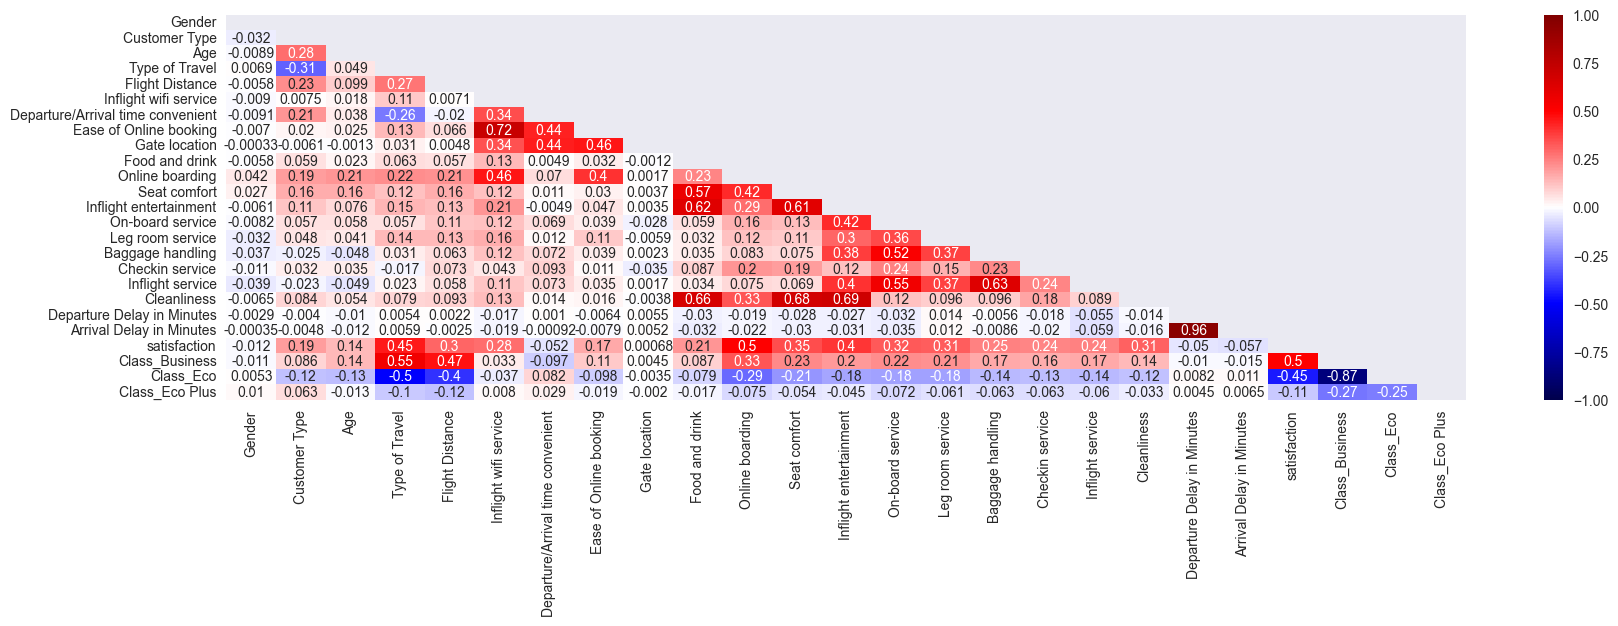

In [11]:
# Матрица корреляций
apdf_corr = apdf.corr()
# Выведем тепловую карту на основе матрицы корреляций
matrix = np.triu(apdf_corr) # Треугольная маска
fig, axes = plt.subplots(figsize=(20, 5))
# Тепловая карта
sns.heatmap(
    apdf_corr, vmin=-1, vmax=1, cmap='seismic',
    annot=True, mask=matrix, ax=axes
);
# Параметры матрицы
print('Число столбцов:', apdf_corr.shape[1])
print('Ранг матрицы:  ', np.linalg.matrix_rank(apdf_corr))
print('Определитель:  ', np.round(np.linalg.det(apdf_corr), 6))

Нулевой определитель говорит о плохой обусловленности матрицы. Ранг матрицы меньше числа столбцов, определитель равен нулю: матрица вырожденная, имеется линейная созависимость между векторами. 

Посмотрим на соотношение классов.

not satisfied: 56.67%
satisfied:     43.33%


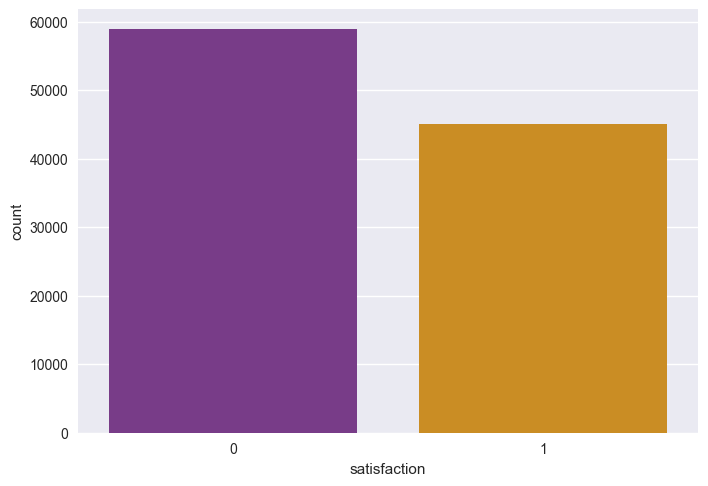

In [12]:
sns.countplot(x='satisfaction', data=apdf, palette='CMRmap')
class_percent = apdf['satisfaction'].value_counts(normalize=True) * 100
print("not satisfied: {:.2f}%".format(class_percent[0]))
print("satisfied:     {:.2f}%".format(class_percent[1]))

Разобьем данные на обучающую и тестовую выборки в соотношении 80/20.

In [13]:
X = apdf.drop('satisfaction', axis=1)
y = apdf['satisfaction']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=26
)
X_train.shape, X_test.shape

((83123, 24), (20781, 24))

Отмасштабируем данных.

In [14]:
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(X_train)
Xtest_scaled = scaler.transform(X_test)

Если бы дальше мы работали только с деревьями, масштабирование бы не требовалось. Однако мы реализуем его, чтобы можно было обучать и другие модели и сравнивать полученные результаты.

## Моделирование

Перейдём к обучению моделей. В качестве первой модели возьмём самую простую — логистическую регрессию. Это будет наш baseline model.

Но сперва напишем функцию для сбора метрик.

In [15]:
# Напишем одну полезную функцию
def metrics_extraction(preds_train, preds_test, train_y, test_y):
    """
    Функция для получения массива значений метрик для
    их дальнейшей печати и предачи в сводную таблицу.
    Args:
        preds_train (np.array): вектор предсказанных значений train-выборки;
        preds_test (np.array): вектор предсказанных значений test-выборки;
        train_y (np.array): вектор истинных значений train-выборки;
        test_y (np.array): вектор истинных значений test-выборки.
    Returns:
        tuple: 
            list: список строк для вывода метрик треннировочной выборки,
            list: список строк для вывода метрик тествовой выборки,
            array: вектор метрик треннировочной выборки,
            array: вектор метрик тествовой выборки.
    """
    
    precision_train = metrics.precision_score(train_y, preds_train)
    precision_test = metrics.precision_score(test_y, preds_test)
    recall_train = metrics.recall_score(train_y, preds_train)
    recall_test = metrics.recall_score(test_y, preds_test)
    f1_train = metrics.f1_score(train_y, preds_train)
    f1_test = metrics.f1_score(test_y, preds_test)
    accuracy_train = metrics.accuracy_score(train_y, preds_train)
    accuracy_test = metrics.accuracy_score(test_y, preds_test)
    roc_auc_train = metrics.roc_auc_score(train_y, preds_train)
    roc_auc_test = metrics.roc_auc_score(test_y, preds_test)
    
    train_print_lst = [
        'Train metrics:',
        f'Precision: {round(precision_train, 3)}',
        f'Recall:    {round(recall_train, 3)}',
        f'F1 score:  {round(f1_train, 3)}',
        f'Accuracy:  {round(accuracy_train, 3)}',
        f'ROC-AUC:   {round(roc_auc_train, 3)}'
    ]
    
    test_print_lst = [
        'Test metrics:',
        f'Precision: {round(precision_test, 3)}',
        f'Recall:    {round(recall_test, 3)}',
        f'F1 score:  {round(f1_test, 3)}',
        f'Accuracy:  {round(accuracy_test, 3)}',
        f'ROC-AUC:   {round(roc_auc_test, 3)}'
    ]
    
    train_array = np.array([
        precision_train, recall_train, f1_train, accuracy_train, roc_auc_train
    ])
    
    test_array = np.array([
        precision_test, recall_test, f1_test, accuracy_test, roc_auc_test
    ])
    
    return train_print_lst, test_print_lst, train_array, test_array

### Baseline LogisticRegression

Обучим логистическую регрессию с параметрами по умолчанию на наших данных.

In [16]:
# Инициализация
lgr = LogisticRegression()
# Обучение
lgr.fit(Xtrain_scaled, y_train)
# Предсказание
preds_train_lgr = lgr.predict(Xtrain_scaled)
preds_test_lgr = lgr.predict(Xtest_scaled)

# Получение метрик
train_print_logr, test_print_logr, train_array_logr, test_array_logr = metrics_extraction(
    preds_train_lgr, preds_test_lgr, y_train, y_test
)

# Вывод метрик
print(*train_print_logr, sep='\n', end='\n\n')
print(*test_print_logr, sep='\n')

Train metrics:
Precision: 0.87
Recall:    0.835
F1 score:  0.852
Accuracy:  0.875
ROC-AUC:   0.87

Test metrics:
Precision: 0.874
Recall:    0.833
F1 score:  0.853
Accuracy:  0.876
ROC-AUC:   0.871


### AdaBoost

Теперь перейдём к бустингу. Начнём с обучения первой модели — AdaBoost. В качестве базовой модели для неё возьмем решающее дерево с параметром random_state = 26.

Обучите AdaBoost, зафиксировав random_state со значением 26 и задав темп обучения 0.01.

In [17]:
# Инициализация
ab = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(
        random_state=26
    ),
    learning_rate=0.01
)
# Обучение
ab.fit(Xtrain_scaled, y_train)
# Предсказание
preds_train_ab = ab.predict(Xtrain_scaled)
preds_test_ab = ab.predict(Xtest_scaled)

# Получение метрик
train_print_ab, test_print_ab, train_array_ab, test_array_ab = metrics_extraction(
    preds_train_ab, preds_test_ab, y_train, y_test
)

# Вывод метрик
print(*train_print_ab, sep='\n', end='\n\n')
print(*test_print_ab, sep='\n')

Train metrics:
Precision: 1.0
Recall:    1.0
F1 score:  1.0
Accuracy:  1.0
ROC-AUC:   1.0

Test metrics:
Precision: 0.936
Recall:    0.939
F1 score:  0.937
Accuracy:  0.946
ROC-AUC:   0.945


### GradientBoostingClassifier

Перейдем к следующему алгоритму — градиентному бустингу.

Будем настраивать количество деревьев и темп обучения, делая перебор по следующей сетке:

In [18]:
params = {"n_estimators":2**np.arange(8), "learning_rate":0.1**np.arange(3)}

Воспользуемся для поиска оптимальных параметров GridSearchCV.

In [19]:
%%time
# Инициализация бустера
gbc_for_gs = GradientBoostingClassifier()
# Инициализация оптимизатора
gs = GridSearchCV(
    gbc_for_gs,
    params, cv=5,
    scoring=metrics.make_scorer(metrics.f1_score)
    )
# Обучение
gs.fit(Xtrain_scaled, y_train)
# Предсказание
preds_train_gs = gs.predict(Xtrain_scaled)
preds_test_gs = gs.predict(Xtest_scaled)

# Получение метрик
train_print_gs, test_print_gs, train_array_gs, test_array_gs = metrics_extraction(
    preds_train_gs, preds_test_gs, y_train, y_test
)

# Вывод метрик
print(*train_print_gs, sep='\n', end='\n\n')
print(*test_print_gs, sep='\n')

Train metrics:
Precision: 0.969
Recall:    0.948
F1 score:  0.958
Accuracy:  0.964
ROC-AUC:   0.962

Test metrics:
Precision: 0.962
Recall:    0.941
F1 score:  0.951
Accuracy:  0.958
ROC-AUC:   0.956
CPU times: total: 5min 25s
Wall time: 5min 25s


### XGBoost

Обучим алгоритм XGBoost. Так как он достаточно мощный «из коробки», определим его с параметрами по умолчанию, только задайте random_state = 26.

In [20]:
# Инициализация
xgb = XGBClassifier(random_state=26)
# Обучение
xgb.fit(Xtrain_scaled,y_train)

# Предсказание
preds_train_xgb = xgb.predict(Xtrain_scaled)
preds_test_xgb = xgb.predict(Xtest_scaled)

# Получение метрик
train_print_xgb, test_print_xgb, train_array_xgb, test_array_xgb = metrics_extraction(
    preds_train_xgb, preds_test_xgb, y_train, y_test
)

# Вывод метрик
print(*train_print_xgb, sep='\n', end='\n\n')
print(*test_print_xgb, sep='\n')

Train metrics:
Precision: 0.984
Recall:    0.961
F1 score:  0.973
Accuracy:  0.976
ROC-AUC:   0.975

Test metrics:
Precision: 0.973
Recall:    0.943
F1 score:  0.958
Accuracy:  0.964
ROC-AUC:   0.961


### CatBoost

Обучим алгоритм CatBoost. Как и XGBoost, будем обучать его с настройками по умолчанию и заданным random_state = 26.

In [21]:
# Инициализация
cbc = CatBoostClassifier(random_state=26, verbose=False)
# Обучение
cbc.fit(Xtrain_scaled,y_train)

# Предсказание
preds_train_cbc = cbc.predict(Xtrain_scaled)
preds_test_cbc = cbc.predict(Xtest_scaled)

# Получение метрик
train_print_cbc, test_print_cbc, train_array_cbc, test_array_cbc = metrics_extraction(
    preds_train_cbc, preds_test_cbc, y_train, y_test
)

# Вывод метрик
print(*train_print_cbc, sep='\n', end='\n\n')
print(*test_print_cbc, sep='\n')

Train metrics:
Precision: 0.984
Recall:    0.96
F1 score:  0.972
Accuracy:  0.976
ROC-AUC:   0.974

Test metrics:
Precision: 0.975
Recall:    0.944
F1 score:  0.959
Accuracy:  0.965
ROC-AUC:   0.962


## Итог

Сведем в единую таблицу метрики всех моделей.

In [22]:
results = pd.DataFrame(
    index=['Baseline LogReg', 'AdaBoostClassifier', 'GradientBoostingClassifier',
           'XGBClassifier', 'CatBoostClassifier'],
    columns=['precision', 'recall', 'f1', 'accuracy', 'roc-auc'],
    data=[
        list(np.round(test_array_logr, 3)),
        list(np.round(test_array_ab, 3)),
        list(np.round(test_array_gs, 3)),
        list(np.round(test_array_xgb, 3)),
        list(np.round(test_array_cbc, 3))
        ]
)

results

,precision,recall,f1,accuracy,roc-auc
Baseline LogReg,0.874,0.833,0.853,0.876,0.871
AdaBoostClassifier,0.936,0.939,0.937,0.946,0.945
GradientBoostingClassifier,0.962,0.941,0.951,0.958,0.956
XGBClassifier,0.973,0.943,0.958,0.964,0.961
CatBoostClassifier,0.975,0.944,0.959,0.965,0.962


Наш победитель - CatBoostClassifier.

Выведем матрицу ошибок для алгоритма. Значения в матрице ошибок переведены в проценты от общего числа наблюдений в тестовой выборке и округлены до целых.

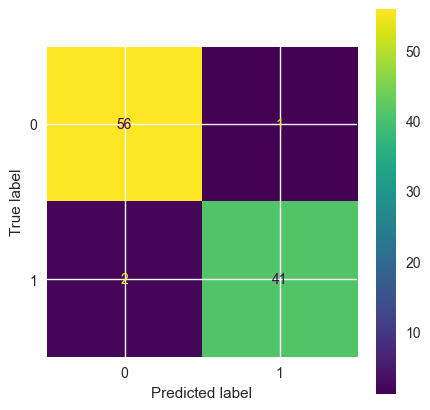

In [23]:
# Высчитаем матрицу ошибок
cm = np.round(metrics.confusion_matrix(y_test, preds_test_cbc, normalize='all')*100)
# 
plt.rcParams['figure.figsize'] = (5,5)
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=cbc.classes_
)
disp.plot();

Оценим важность признаков для модели.

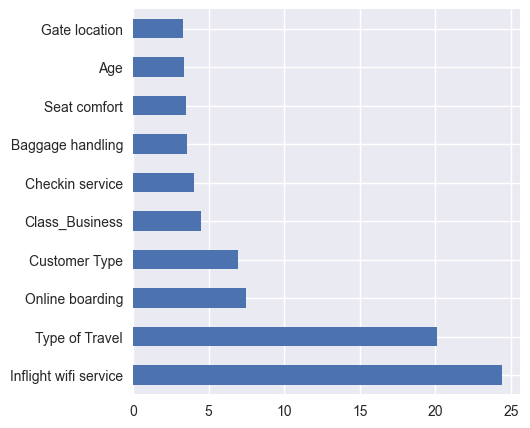

In [24]:
plt.rcParams['figure.figsize'] = (5,5)
feat_importances = pd.Series(cbc.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh');

Модель на классификаторе CatBoost говорит, что на качество предсказания сильнее всего влияет уровень удовлетворенности доступом к беспроводному интернету во время полета, а также тип поездки. 